# OpenStreetMap Exposures

This module contains two sub-modules:

   `osm_dataloader.py`, which handles the loading of raw map data and the extraction of specific info into useful geodataframe formats 
    
   `osm_exposuremaker`, which deals with the step of converting map info into `climada.exposures` as well as some links to the `LitPop` exposure.

## Part 1: Downloading openstreetmap data (osm_dataloader)

  This module provides 3 "pathways" to get to map data in geodataframe formats. They are illustrated below.
  The functionalities are contained in 3 classes:
  * `OSMRaw` - methods to download raw map datafiles from servers, at country or planet-scale.
  * `OSMFileQuery` - methods to extract specific info from the raw files and assemble them into gdfs.
  * `OSMApiQuery` - methods to directly load specific map info & assemble into gdfs, via the overpass-turbo API.

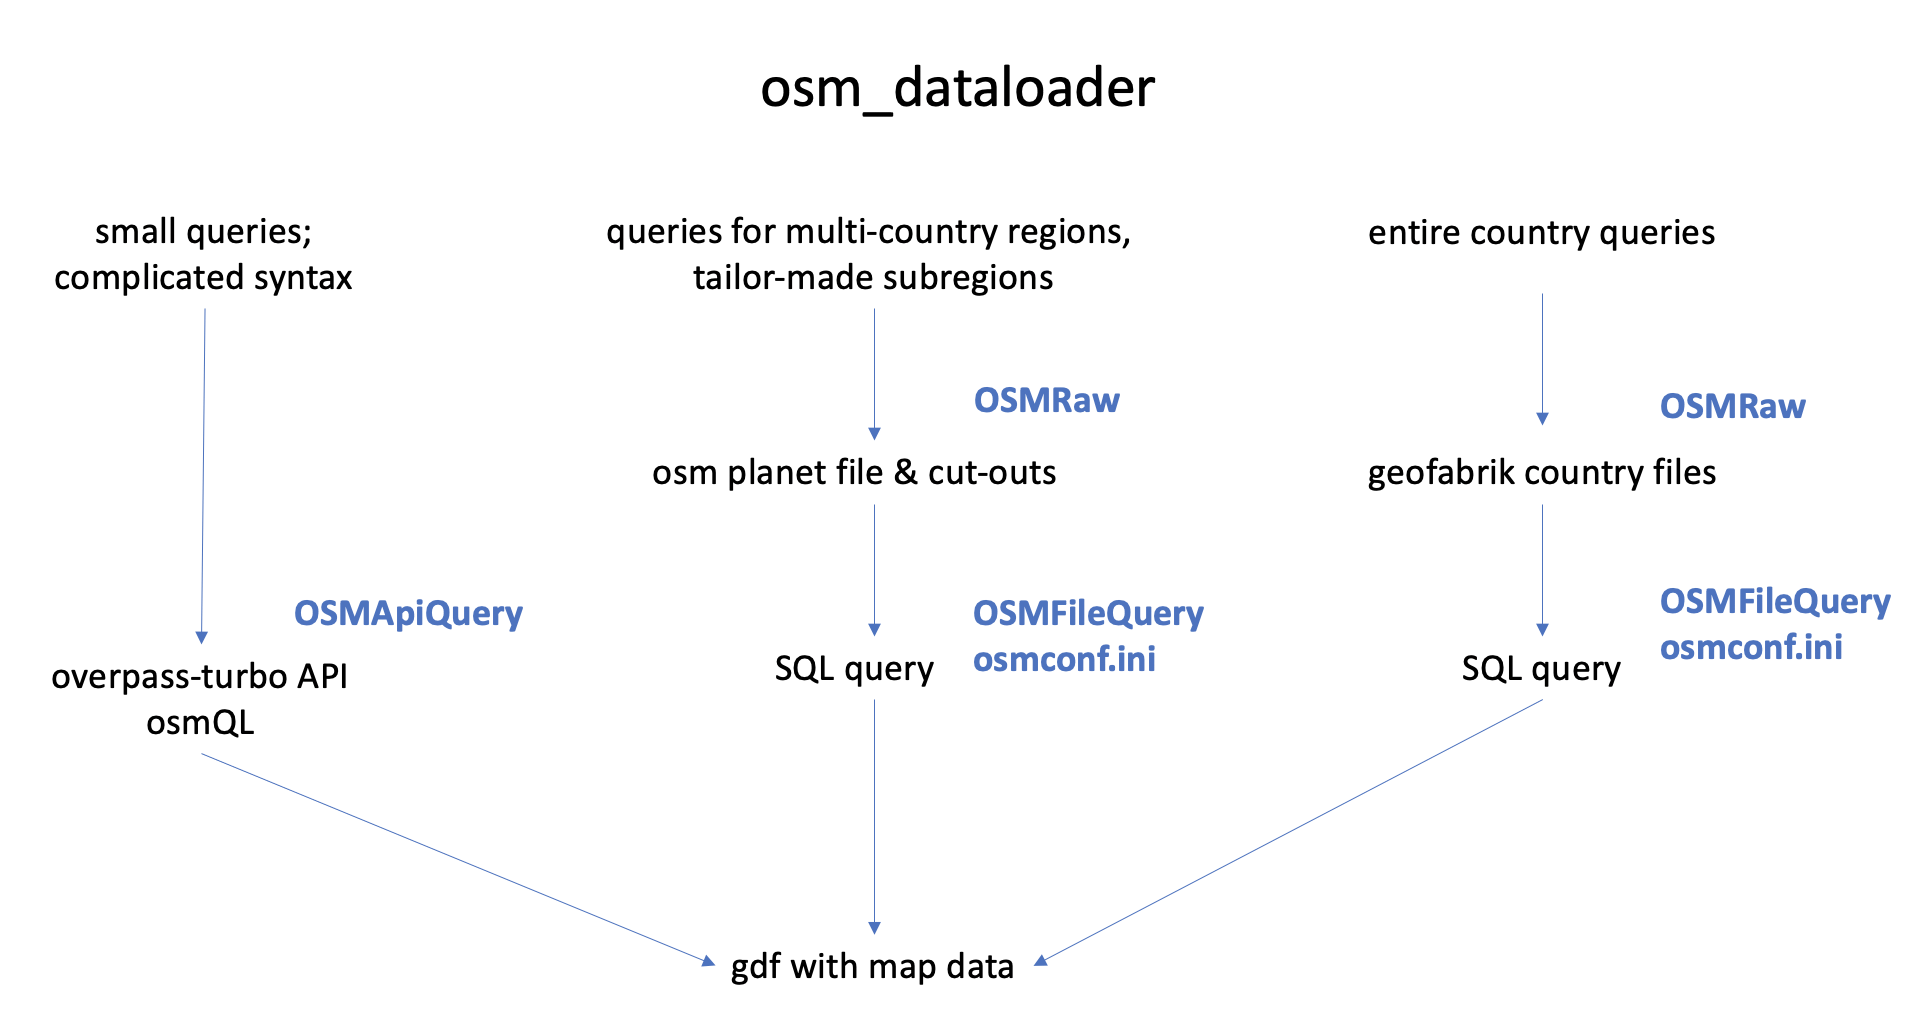

### Foreword: OSM overpass-turbo, Overpass QL & OSM data structures (nodes, ways, relations)

Check out https://taginfo.openstreetmap.org/ for finding the key-value pairs ("tags") you're looking for.

Check out https://overpass-turbo.eu/ for a fast visual overview on results that your query will yield.

The osm api has constraints on how much can be downloaded at once (reached quite fast, especially around mid-day / early afternoon..). Wait-times implemented in the querying, but re-consider your strategy if you run into a time-out error.

Overpass Query language can be a bit cryptic. The majority of what you will need is handled in the OSMApiQuery automatically.
For more, check out the detailed read-the-docs: https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL 

From https://wiki.openstreetmap.org/wiki/Elements : 

Elements are the basic components of OpenStreetMap's conceptual data model of the physical world. Elements are of three types:

* nodes (defining points in space),
* ways (defining linear features and area boundaries), and
* relations (which are sometimes used to explain how other elements work together).

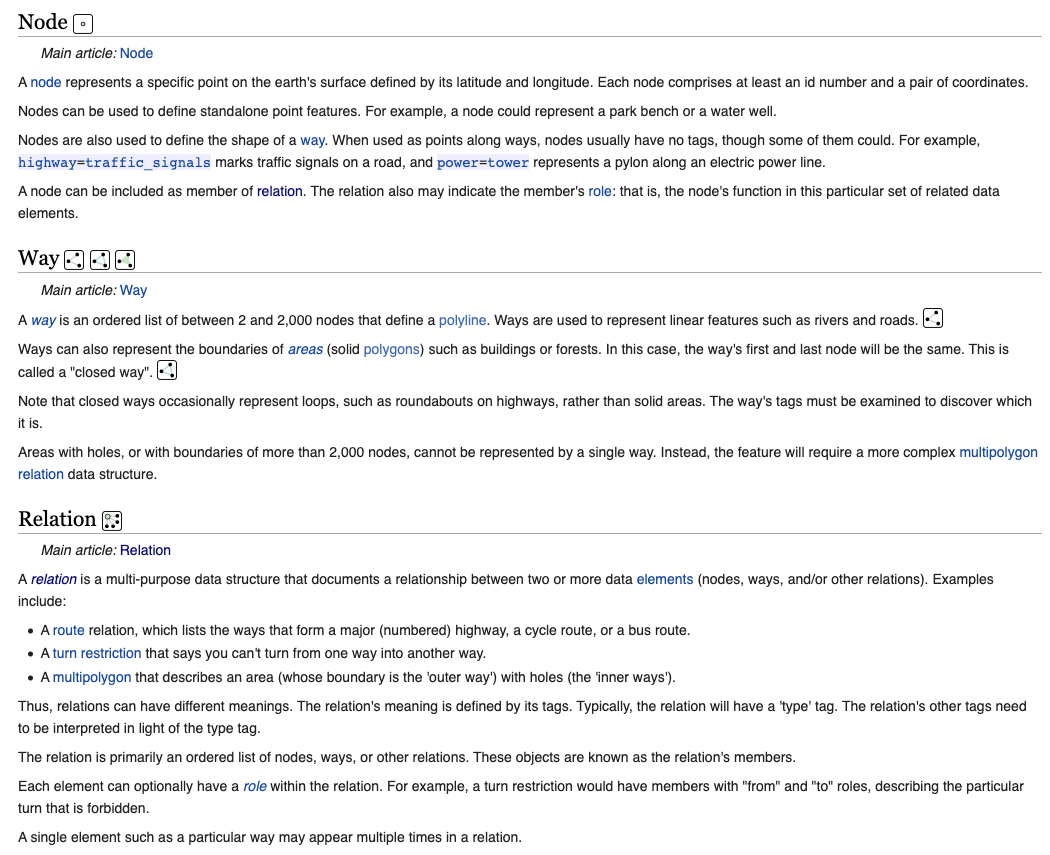

### Example 1: Country data extracts ("right" path)

In this example, the entire map info for a country (in this case Honduras) is downloaded from a host server (geofabrik.de). Geofabrik provides two formats: shapefiles (.shp) and protocol binary format (.pbf). The latter has much smaller file sizes. In the second step, specific info can be extracted from the raw files, unsing the OSMFileQuery. The query functions work for .pbf format only (since shapefiles can be directly read into gdfs and filtered afterwards).

In [1]:
import matplotlib.pyplot as plt
import shapely
import contextily as ctx
from climada.entity.exposures.openstreetmap.osm_dataloader import OSMRaw, OSMApiQuery, OSMFileQuery

In [2]:
# download osm.pbf file for Honduras from geofabrik (checks if file already exists)
PATH_OSM_DATA = '/Users/evelynm/Documents/WCR/3_PhD/1_coding_stuff/x_data/osm_countries'
OSMRaw().get_data_geofabrik('HND', file_format='pbf', save_path=PATH_OSM_DATA)

2021-07-22 11:05:33,010 - climada.entity.exposures.openstreetmap.osm_dataloader - INFO - file already exists as /Users/evelynm/Documents/WCR/3_PhD/1_coding_stuff/x_data/osm_countries/honduras-latest.osm.pbf


In [3]:
# Initiate a OSMFileQuery instance with the downloaded file.
path_osm_hnd = '/Users/evelynm/Documents/WCR/3_PhD/1_coding_stuff/x_data/osm_countries/honduras-latest.osm.pbf'
HNDFileQuery = OSMFileQuery(path_osm_hnd)

### 1.1 Pre-written Critical Infrastructure Wrappers
For critical infrastructures, a set of wrappers exist that perform the query under the hood. They collect a range of applicable tags from openstreetmap that go under the respective infrastructure type and load all of them into one dataframe. The reported columns and tags that are queried can be inspected (and modified) in the dictionary `DICT_CIS_OSM`:

In [5]:
from climada.entity.exposures.openstreetmap.osm_dataloader import DICT_CIS_OSM

In [7]:
# check available critical infrastructure types:
DICT_CIS_OSM.keys()

dict_keys(['education', 'healthcare', 'water', 'telecom', 'road', 'rail', 'air', 'gas', 'oil', 'power', 'wastewater', 'food'])

In [8]:
# lets extract all roads from the Honduras file, via the CI-wrapper
gdf_roads = HNDFileQuery.retrieve_cis('road')

2021-07-22 11:10:51,150 - climada.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract points: 0it [00:00, ?it/s]

2021-07-22 11:10:52,849 - climada.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop



extract multipolygons: 100%|██████████| 2/2 [00:19<00:00,  9.61s/it]

2021-07-22 11:11:31,889 - climada.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop



extract lines: 100%|██████████| 5591/5591 [00:03<00:00, 1471.63it/s]


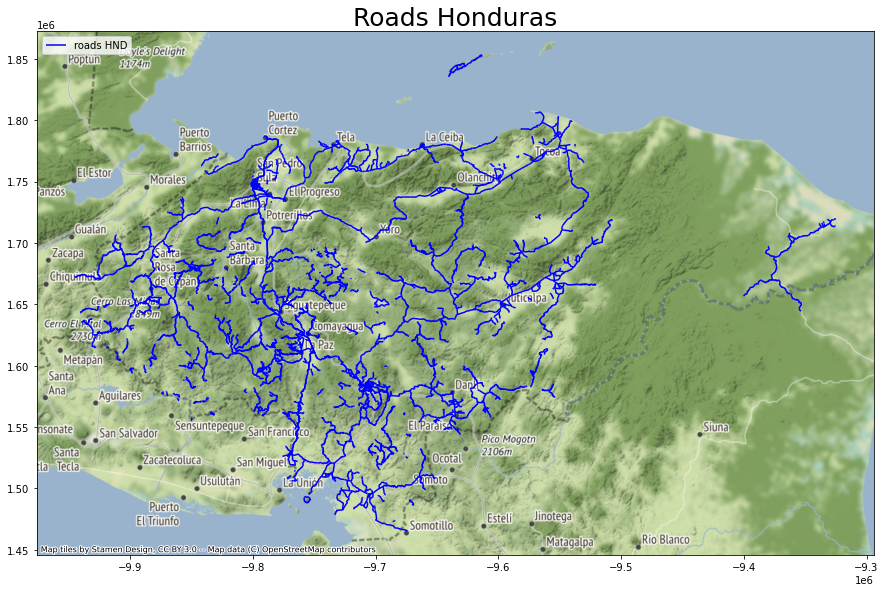

In [9]:
# plot results
ax = gdf_roads.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='blue', 
                    edgecolor='blue', label='roads HND')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Roads Honduras', fontsize=25)
ctx.add_basemap(ax)
plt.show()

### 1.2 Self-written query constraints
Any other tags that are available on openstreetmap can also be queried with the `retrieve()` method.
A constraint dictionary has to be specified, whith both the keys (columns to report in the gdf) and the query (key-value constraints). 

In [10]:
# Forests in HND.
constraint_dict = {'osm_keys' : ['landuse'],
                   'osm_query' : """landuse='forest'"""}
gdf_forest = HNDFileQuery.retrieve('multipolygons', constraint_dict)

2021-07-22 11:14:56,108 - climada.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract multipolygons: 100%|██████████| 689/689 [00:05<00:00, 132.40it/s]


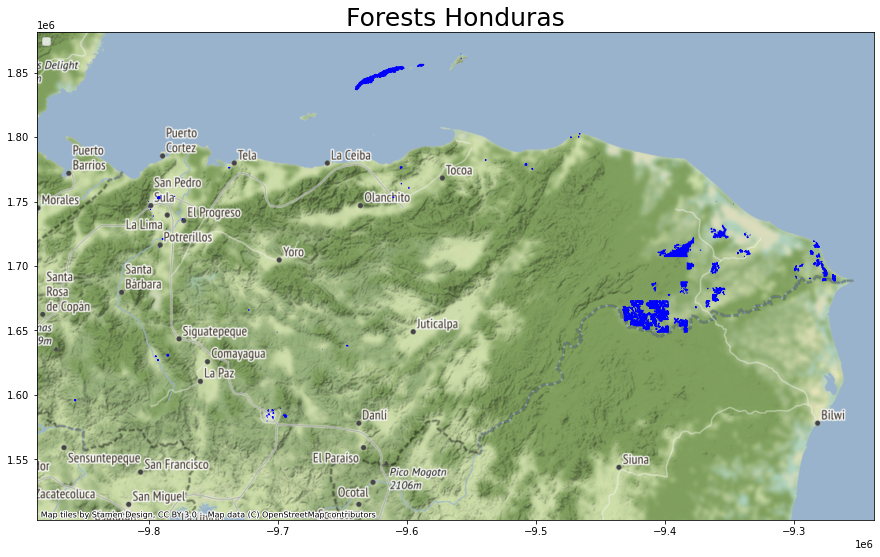

In [11]:
# Plot results
ax = gdf_forest.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='blue', 
                    edgecolor='blue', label='forests HND')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Forests Honduras', fontsize=25)
ctx.add_basemap(ax)
plt.show()

## Example 2: Custom-shape region extracts

1. Shape file of your desired region --> convert to .poly file.     
    
        How? See e.g. https://github.com/ElcoK/osm_clipper for admin3 to admin1 level shape conversions.
        Also, some command line tools, like osm_convert
   Bounding box --> just pass the list [xmin, ymin, xmax, ymax]


2. osm planet file --> cut out the desired region (via command line tool osmosis under the hood). Yields a new osm.pbf file


3. rest is the same as the example before, using the newly created file.

In [ ]:
planet_file_path = '/Users/evelynm/Documents/WCR/3_PhD/1_coding_stuff/x_data/osm_countries'
poly_file_path = '/Users/evelynm/Documents/WCR/3_PhD/1_coding_stuff/x_data/osm_countries/country_poly_files/ABW.poly'
bbox_customreg = []

OSMraw().get_data_planetextract(shape= poly_file_path,
                                path_planet=planet_file_path, 
                                path_extract=planet_file_path)

OSMraw().get_data_planetextract(shape= bbox_customreg,
                                path_planet=planet_file_path, 
                                path_extract=planet_file_path)

In [ ]:
path_customreg = '/Users/evelynm/Documents/WCR/3_PhD/1_coding_stuff/x_data/osm_countries/customreg.osm.pbf'
CustomRegFileQuery = OSMFileQuery(path_customreg)

# Example 3: Local data API extracts

### 3.2 Example: Buildings & Churches in the city of Zurich

In [2]:
#area = (47.368260,8.5327506,47.376877,8.5486078)
area = shapely.geometry.Polygon([(47.368260, 8.5327506), (47.376877, 8.5486078), (47.39, 8.5486078)])
condition_church = '["amenity"="place_of_worship"]'
condition_builidng = '["building"]'

zrh_churchquery = OSMApiQuery(area, condition_church)
zrh_buildingquery = OSMApiQuery(area, condition_builidng)

In [3]:
zrh_churchquery.area

'(poly:"47.36826 8.5327506 47.376877 8.5486078 47.39 8.5486078 47.36826 8.5327506")'

In [4]:
gdf_zrh_churches = zrh_churchquery.get_data_overpass()

/Users/evelynm/climada_python/climada/entity/exposures/openstreetmap/osm_dataloader.py:871: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data=np.array([data_id,data_geom,data_tags]).T,


In [27]:
gdf_zrh_buildings = zrh_buildingquery.get_data_overpass()

2021-07-21 17:31:50,206 - climada.entity.exposures.openstreetmap.osm_dataloader - INFO - Empty geometry encountered.
2021-07-21 17:31:50,248 - climada.entity.exposures.openstreetmap.osm_dataloader - INFO - Empty geometry encountered.
2021-07-21 17:31:50,292 - climada.entity.exposures.openstreetmap.osm_dataloader - INFO - Empty geometry encountered.
2021-07-21 17:31:50,306 - climada.entity.exposures.openstreetmap.osm_dataloader - INFO - Empty geometry encountered.


/Users/evelynm/climada_python/climada/entity/exposures/openstreetmap/osm_dataloader.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data=np.array([data_id,data_geom,data_tags]).T,


In [21]:
gdf_zrh_churches

,osm_id,geometry,tags
0,5937142,"POLYGON ((47.37944 8.54536, 47.37937 8.54517, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
1,80340830,"POLYGON ((47.37279 8.53661, 47.37289 8.53676, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
2,89469961,"POLYGON ((47.37177 8.53964, 47.37166 8.53929, ...","{'addr:housenumber': '2', 'addr:street': 'Münz..."
3,108459541,"POLYGON ((47.38237 8.54645, 47.38252 8.54631, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
4,108517666,"POLYGON ((47.38372 8.54672, 47.38377 8.54667, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
5,473379001,POINT (47.37638 8.54548),"{'amenity': 'place_of_worship', 'denomination'..."
6,2960912930,POINT (47.37560 8.54500),"{'amenity': 'place_of_worship', 'name': 'Gemei..."
7,4424615152,POINT (47.37804 8.54029),"{'amenity': 'place_of_worship', 'layer': '-1',..."


<AxesSubplot:>

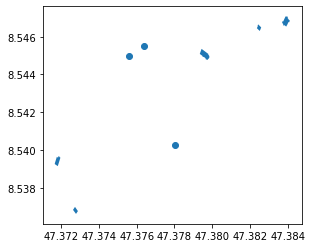

In [22]:
gdf_zrh_churches.plot()

<AxesSubplot:>

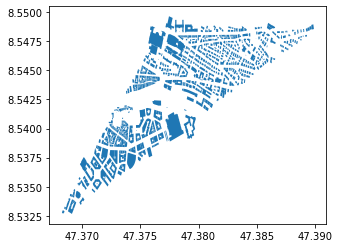

In [23]:
gdf_zrh_buildings.plot()

# Outlook

* API Query: More flexible area entries (bbox, polygons, location names)
* API Query: Error / exception handling in geometry construction
* API Query: allow specification of query levels (nodes / ways / relations)?

* File Query: desired polygons to .poly format for cutting: remains outsourced (?)


* exposuremaker: another discussion on useful functionalities to keep / throw away